In [1]:
import os

os.chdir("/workspaces/example_digital-twin_incubator_twright/software/incubator")

In [2]:
import sys

sys.path.append("/workspaces/example_digital-twin_incubator_twright/software")

In [3]:
import matplotlib.pyplot as plt

In [4]:
plt.rcParams['figure.figsize'] = [60/2.54, 30/2.54]

## Incubator initial

In [5]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import SelfAdaptationTests

In [6]:
#s = SelfAdaptationTests().test_run_self_adaptation()

In [7]:
from incubator.tests.self_adaptation_tests.test_self_adaptation import *

In [8]:
import numpy as np
from oomodelling import Model

from incubator.calibration.calibrator import Calibrator
from incubator.self_adaptation.controller_optimizer import IControllerOptimizer
from incubator.interfaces.updateable_kalman_filter import IUpdateableKalmanFilter

In [9]:
class SelfAdaptationManager:
    def __init__(self, anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                 calibrator: Calibrator,
                 kalman_filter: IUpdateableKalmanFilter,
                 controller_optimizer: IControllerOptimizer):
        assert 0 < ensure_anomaly_timer
        assert 0 < gather_data_timer
        assert 0 < anomaly_threshold
        self.current_state = "Listening"
        self.anomaly_threshold = anomaly_threshold
        self.gather_data_timer = gather_data_timer
        self.cool_down_timer = cool_down_timer
        self.ensure_anomaly_timer = ensure_anomaly_timer
        self.temperature_residual_abs = 0.0
        self.anomaly_detected = False
        self.kalman_filter = kalman_filter
        self.controller_optimizer = controller_optimizer
        self.signals = []

        # Holds the next sample for which an action has to be taken.
        self.next_action_timer = -1
        self.calibrator = calibrator
        self.time_anomaly_start = -1.0

    def reset(self):
        self.current_state = "Listening"
        self.next_action_timer = -1
        self.anomaly_detected = False
        self.time_anomaly_start = -1.0

    def step(self, real_temperature, predicted_temperature, time_s, skip_anomaly_detection=False):
        self.temperature_residual_abs = np.absolute(real_temperature - predicted_temperature)

        if self.current_state == "Listening":
            assert not self.anomaly_detected
            assert self.next_action_timer < 0
            if skip_anomaly_detection:
                self.time_anomaly_start = time_s
                self.current_state = "GatheringData"
                self.next_action_timer = self.gather_data_timer
                self.anomaly_detected = True
            else:
                if self.temperature_residual_abs >= self.anomaly_threshold:
                    self.time_anomaly_start = time_s
                    self.next_action_timer = self.ensure_anomaly_timer
                    self.current_state = "EnsuringAnomaly"
            return
        if self.current_state == "EnsuringAnomaly":
            assert not self.anomaly_detected
            assert self.next_action_timer >= 0

            if self.next_action_timer > 0:
                self.next_action_timer -= 1

            if self.temperature_residual_abs < self.anomaly_threshold:
                self.reset()
                return

            if self.next_action_timer == 0:
                assert self.temperature_residual_abs >= self.anomaly_threshold
                self.current_state = "GatheringData"
                self.next_action_timer = self.gather_data_timer
                self.anomaly_detected = True
                return

            return
        if self.current_state == "GatheringData":
            assert self.anomaly_detected
            assert self.next_action_timer >= 0
            if self.next_action_timer > 0:
                self.next_action_timer -= 1
            if self.next_action_timer == 0:
                self.current_state = "Calibrating"
                self.next_action_timer = -1
            return
        if self.current_state == "Calibrating":
            assert self.time_anomaly_start >= 0.0
            assert self.time_anomaly_start <= time_s
            success, C_air, G_box, C_heater, G_heater = self.calibrator.calibrate(self.time_anomaly_start, time_s)

            # Can we insert the verified model here?
            

            if success:
                self.kalman_filter.update_parameters(C_air, G_box, C_heater, G_heater)
                self.controller_optimizer.optimize_controller()

                self.current_state = "CoolingDown"
                self.next_action_timer = self.cool_down_timer
                self.anomaly_detected = False
            return
        if self.current_state == "CoolingDown":
            assert not self.anomaly_detected
            assert self.next_action_timer >= 0
            if self.next_action_timer > 0:
                self.next_action_timer -= 1
            if self.next_action_timer == 0:
                self.reset()
            return



In [10]:
config = load_config("startup.conf")

n_samples_period = config["physical_twin"]["controller_open_loop"]["n_samples_period"]
n_samples_heating = 5
C_air = config["digital_twin"]["models"]["plant"]["param4"]["C_air"]
G_box = config["digital_twin"]["models"]["plant"]["param4"]["G_box"]
G_box_kf = G_box
C_heater = config["digital_twin"]["models"]["plant"]["param4"]["C_heater"]
G_heater = config["digital_twin"]["models"]["plant"]["param4"]["G_heater"]
initial_box_temperature = 41
initial_heat_temperature = 47
initial_room_temperature = 21  # TODO: Add this parameter to config file.
std_dev = 0.001
step_size = 3.0
anomaly_threshold = 2.0
# Time spent before declaring that there is an self_adaptation_manager, after the first time the self_adaptation_manager occurred.
ensure_anomaly_timer = 1
# Time spent, after the self_adaptation_manager was declared as detected, just so enough data about the system is gathered.
# The data used for recalibration will be in interval [time_first_occurrence, time_data_gathered]
gather_data_timer = 10
cool_down_timer = 5
optimize_controller = True

conv_xatol = 0.1
conv_fatol = 0.1
max_iterations = 200
desired_temperature = 41
max_t_heater = 60
restrict_T_heater = True

# Supervisor parameters
trigger_optimization_threshold = 10.0
heater_underused_threshold = 10.0
wait_til_supervising_timer = 100  # N steps supervisor should wait before kicking in.

tf = 6000

kalman = KalmanFilter4P(step_size, std_dev,
                        C_air, G_box_kf, C_heater, G_heater,
                        initial_room_temperature, initial_heat_temperature, initial_box_temperature)

database = MockDatabase(step_size)
plant_simulator = PlantSimulator4Params()
calibrator = Calibrator(database, plant_simulator, conv_xatol, conv_fatol, max_iterations)
pt_simulator = SystemModel4ParametersOpenLoopSimulator()
ctrl = MockController()

if optimize_controller:
    ctrl_optimizer = ControllerOptimizer(database, pt_simulator, ctrl, conv_xatol, conv_fatol, max_iterations, restrict_T_heater, desired_temperature, max_t_heater)
else:
    ctrl_optimizer = NoOPControllerOptimizer()

anomaly_detector = SelfAdaptationManager(anomaly_threshold, ensure_anomaly_timer, gather_data_timer, cool_down_timer,
                                         calibrator, kalman, ctrl_optimizer)
# supervisor = SupervisorPeriodicSM(ctrl_optimizer, wait_til_supervising_timer)
supervisor = SupervisorThresholdSM(ctrl_optimizer, desired_temperature, max_t_heater,
                                   trigger_optimization_threshold, heater_underused_threshold,
                                   wait_til_supervising_timer)

m = SelfAdaptationScenario(n_samples_period, n_samples_heating,
                           C_air, G_box, C_heater, G_heater,
                           initial_box_temperature,
                           initial_heat_temperature,
                           initial_room_temperature,
                           kalman, anomaly_detector, supervisor,
                           std_dev)

# Inform mock db of plant _plant.
database.set_models(m.physical_twin.plant, m.physical_twin.ctrl)
# Inform mock of controller
ctrl.set_model(m.physical_twin.ctrl)

# Wire in a custom function for the G_box input, so we can change it.
m.physical_twin.plant.G_box = lambda: G_box if m.time() < 1000 else (G_box * 10 if m.time() < 2000 else G_box)

# Wire in a custom function for the C_air parameter,
# so we mimick a different object being placed in the incubator.
# Commented out because it does not seem to work very well.
# m.physical_twin.plant.C_air = lambda: C_air if m.time() < 1000 else (C_air * 7 if m.time() < 2000 else C_air)

ModelSolver().simulate(m, 0.0, tf, 3.0)

/home/sage/sage/local/lib/python3.9/site-packages/scipy/optimize/_minimize.py:535: RuntimeWarning: Method Nelder-Mead cannot handle constraints nor bounds.
  warn('Method %s cannot handle constraints nor bounds.' % method,


  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 12026
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
       5.99459384e+03, 5.99759384e+03, 6.00000000e+03])
 t_events: None
        y: array([[0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       ...,
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.99459384e+03, 5.99759384e+03, 6.00000000e+03],
       [0.00000000e+00, 5.34510279e-04, 5.87961307e-03, ...,
        5.994

Parameters:
C_air:  [145.69782402, 141.71945977643318, 272.01832249938576, 102.28707795820601]
G_box:  [0.79154106, 7.8338353184845495, 8.315644265351954, 1.412942235649828]
C_heater:  [227.76228512, 227.76228512, 227.76228512, 227.76228512]
G_heater:  [1.92343277, 1.92343277, 1.92343277, 1.92343277]


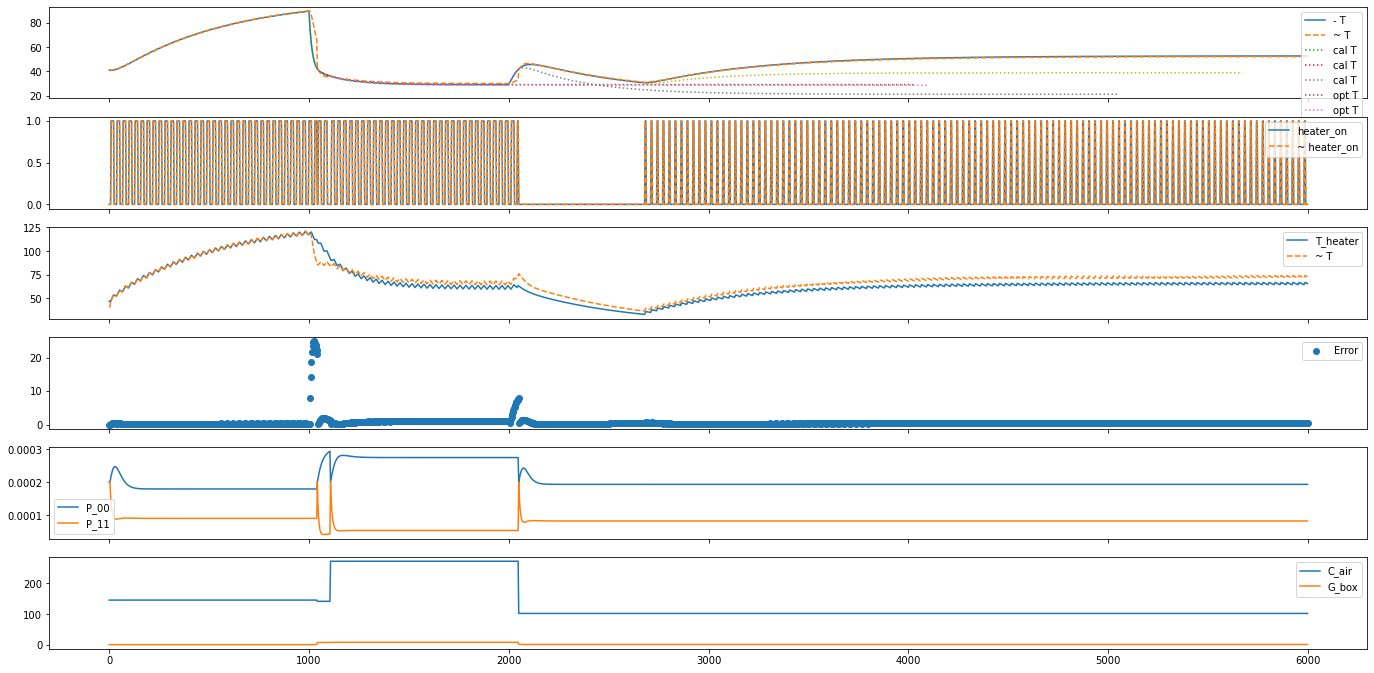

In [11]:
fig, (ax1, ax2, ax3, ax4, ax5, ax6) = plt.subplots(6, 1, sharex='all')

ax1.plot(m.signals['time'], m.physical_twin.plant.signals['T'], label=f"- T")
ax1.plot(m.signals['time'], m.kalman.signals['out_T'], linestyle="dashed", label=f"~ T")
# ax1.plot(m.signals['time'], m.kalman.signals['out_T_prior'], linestyle="dashed", label=f"~ T_prior")

for (times, trajectory) in database.plant_calibration_trajectory_history:
    ax1.plot(times, trajectory[0, :], label=f"cal T", linestyle='dotted')

for (times, T, T_heater, heater_on) in database.ctrl_optimal_policy_history:
    ax1.plot(times, T, label=f"opt T", linestyle='dotted')

ax1.legend()

ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.physical_twin.ctrl.signals['heater_on']], label=f"heater_on")
ax2.plot(m.signals['time'], [(1 if b else 0) for b in m.kalman.signals['in_heater_on']], linestyle="dashed", label=f"~ heater_on")

ax2.legend()

ax3.plot(m.signals['time'], m.physical_twin.plant.signals['T_heater'], label=f"T_heater")
ax3.plot(m.signals['time'], m.kalman.signals['out_T_heater'], linestyle="dashed", label=f"~ T")

ax3.legend()

# The following plot is incorrect, since it does not match with the actual residual computed by the self_adaptation_manager
# ax4.scatter(m.signals['time'],
#             np.absolute(np.array(m.physical_twin.plant.signals['T']) - np.array(m.kalman.signals['out_T'])),
#             label=f"Error")

ax4.scatter(m.signals['time'],
            m.self_adaptation_manager.signals["temperature_residual_abs"],
            label=f"Error")
ax4.legend()

ax5.plot(m.signals['time'], m.kalman.signals['out_P_00'], label=f"P_00")
ax5.plot(m.signals['time'], m.kalman.signals['out_P_11'], label=f"P_11")

ax5.legend()

ax6.plot(m.signals['time'], m.kalman.signals['C_air'], label=f"C_air")
ax6.plot(m.signals['time'], m.kalman.signals['G_box'], label=f"G_box")

ax6.legend()


print("Parameters:")
print("C_air: ", database.C_air)
print("G_box: ", database.G_box)
print("C_heater: ", database.C_heater)
print("G_heater: ", database.G_heater)
plt.show()

## 2 Parameter Model

$$
    \frac{\mathrm d T_{\mathrm{system}}}{\mathrm d t} =
    \frac{1}{C_{\mathrm{system}}}\bigl(
        V I - G_{\mathrm{box}} \bigl(T_{\mathrm{system}} - T_{\mathrm{room}}\bigr)
    \bigr)
$$

$$
    \frac{\mathrm d T_{S}}{\mathrm d t} =
    \frac{1}{C_S}\bigl(
        V I - G_B \bigl(T_S - T_R\bigr)
    \bigr)
$$

In [12]:
from verified_twin.lbuc import *

from sage.symbolic.function_factory import function_factory

from verified_twin.base import *
from verified_twin.parametric_models import IntervalParametricModel
from verified_twin.incubator_models import *

In [13]:
twopincubator.ode_table

  diff(T_S(t), t) == (G_B*(T_R - T_S(t)) + I*V)/C_S

In [14]:
r = twopincubator.reach(100)

In [15]:
p = r.sage_plot(T_S, color="blue", fillcolor='blue', linestyle="--", fill={0: [1]})

plot_points = 10000


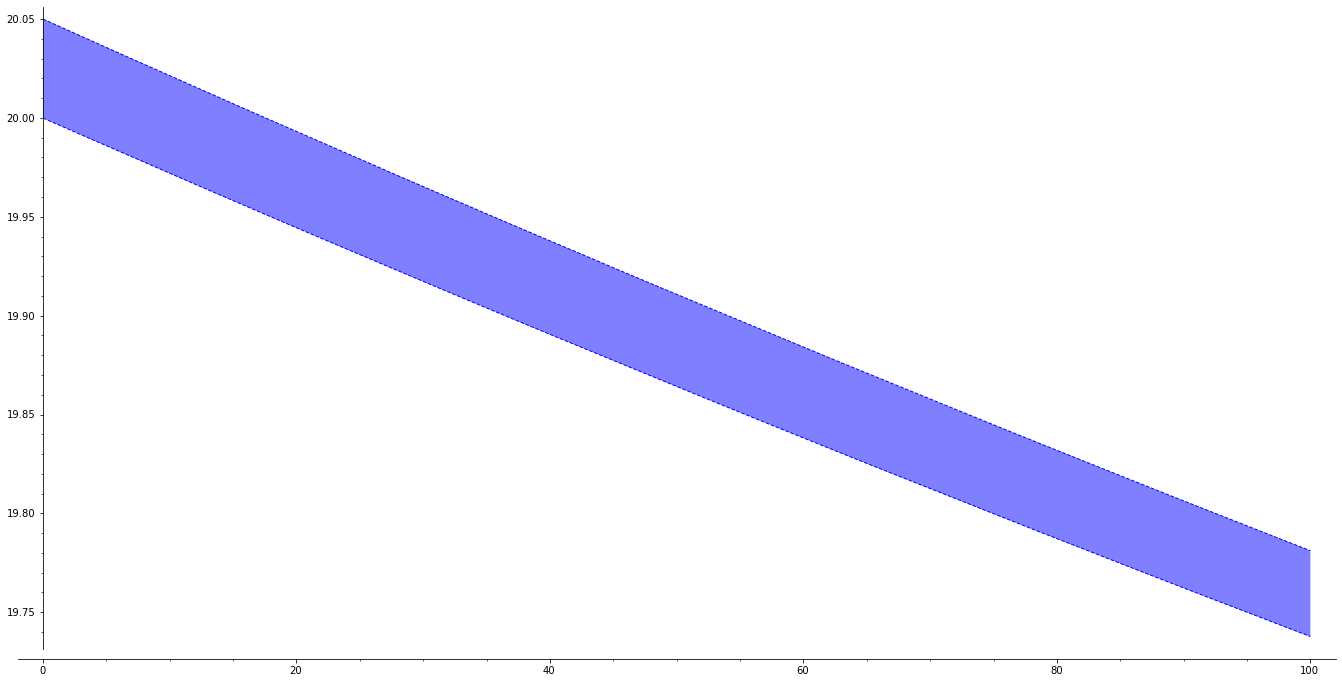

In [16]:
p.matplotlib()

## Verified simulator

In [17]:
from digital_twin.simulator.verified_plant_simulator import VerifiedPlantSimulator4Params

In [18]:
import numpy as np

timepoints = [0.0, 22.0, 53.0, 75.0, 106.0, 128.0, 600]
heater_on =  [True, False, True, False, True, False, False]
room_temp = [21.25, 21.25, 21.25, 21.25, 21.25, 21.25, False]

In [19]:
from sage.all import RIF

In [20]:
res, model = VerifiedPlantSimulator4Params().run_simulation(
    timepoints,
    RIF('[20.5935,24.5935]'),
    RIF('25'),
    room_temp,
    heater_on,
    68.20829072,
    0.73572788,
    243.45802367,
    0.87095429,
)

x = [0, 25, 3.?e1]
state = {'heater_on': True}
running for [22.000000000000000 .. 22.000000000000000] ...
x = [22.000000000?, 36.?, 3.?e1]
state = {'heater_on': False}
running for [30.999999999111523 .. 31.000000000892506] ...
x = [53.00000000?, 35.?, 3.?e1]
state = {'heater_on': True}
running for [21.999999997583117 .. 22.000000003307165] ...
x = [75.00000000?, 45.?, 29.?]
state = {'heater_on': False}
running for [30.999999993174029 .. 31.000000006831343] ...
x = [106.0000000?, 44.?, 31.?]
state = {'heater_on': True}
running for [21.999999991601654 .. 22.000000015245931] ...
x = [128.0000000?, 54.?, 34.?]
state = {'heater_on': False}
running for [471.99999997372304 .. 472.00000001852971] ...


In [21]:
res.values

[{'heater_on': False},
 {'heater_on': True},
 {'heater_on': False},
 {'heater_on': True},
 {'heater_on': False},
 {'heater_on': True},
 {'heater_on': False},

In [22]:
import sage.all as sg

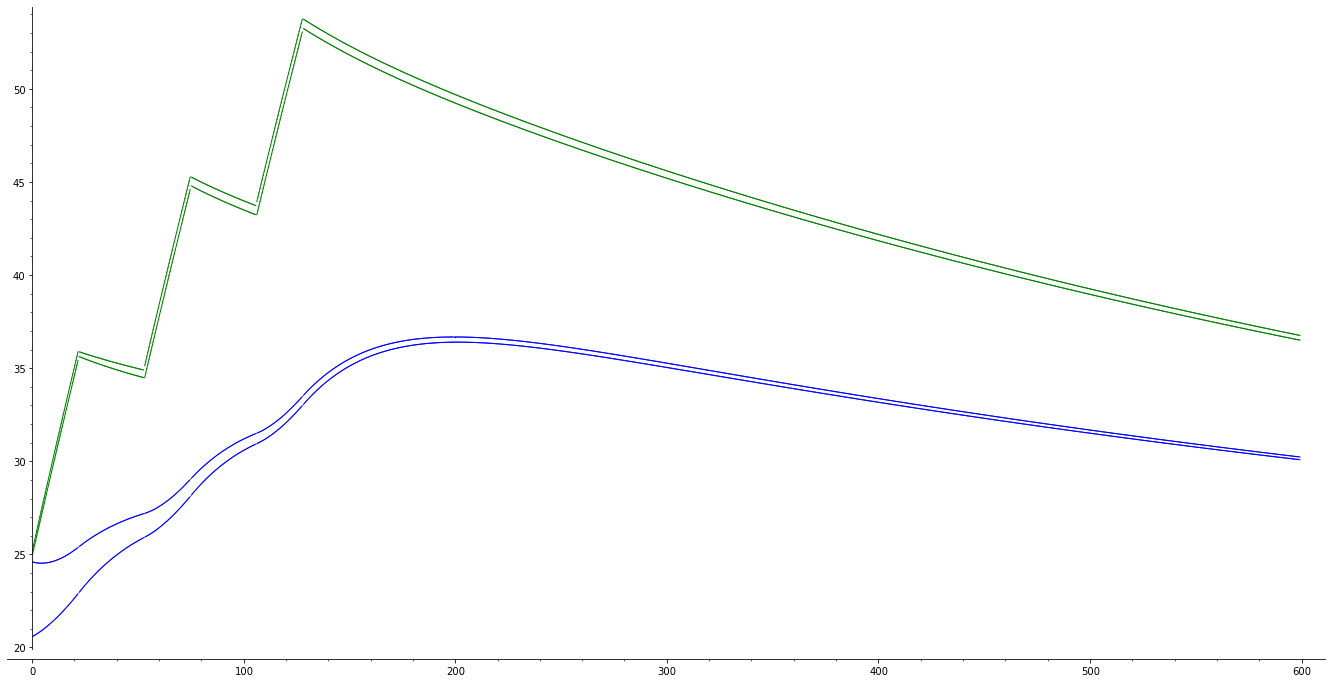

In [23]:
p = res.plot(('T_A', 'T_H'), color=('blue', 'green'))
p.matplotlib()

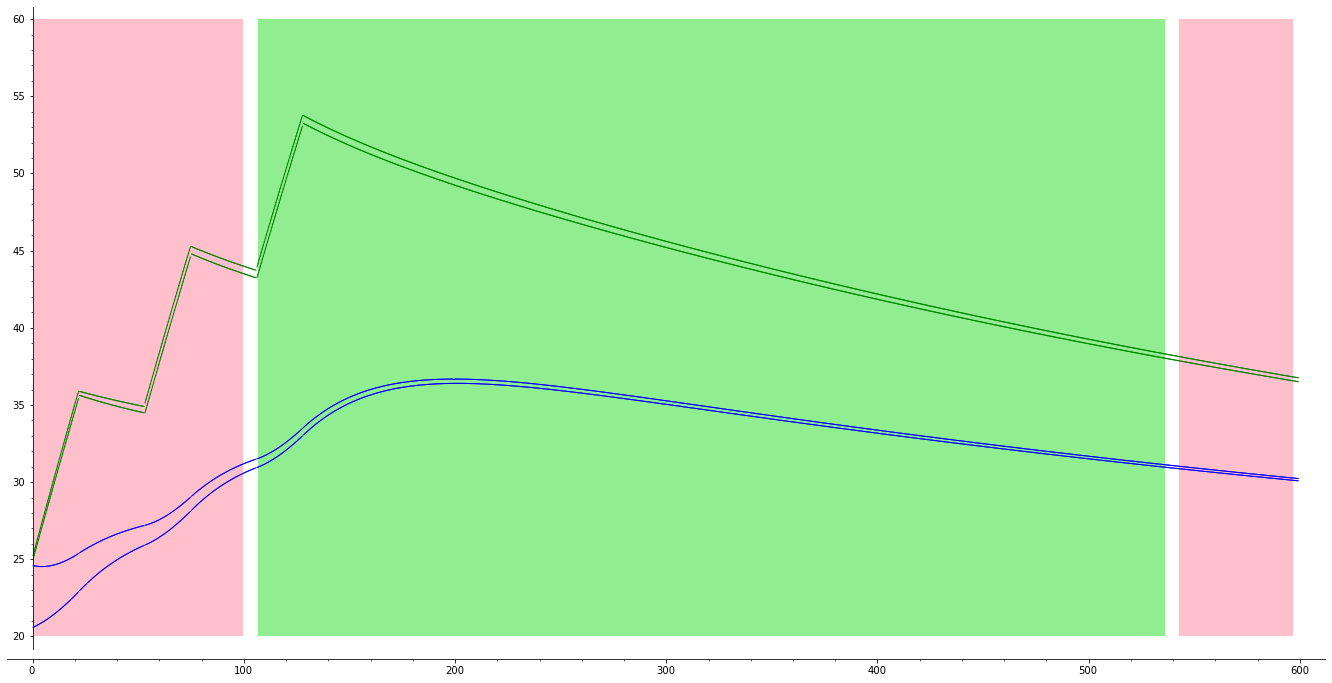

In [24]:
p1 = p + Atomic(T_A > RIF(31)).signal(res).plot(y_range=(20, 60))
p1.set_aspect_ratio('automatic')
p1.matplotlib()

In G.signal
mask for G = None


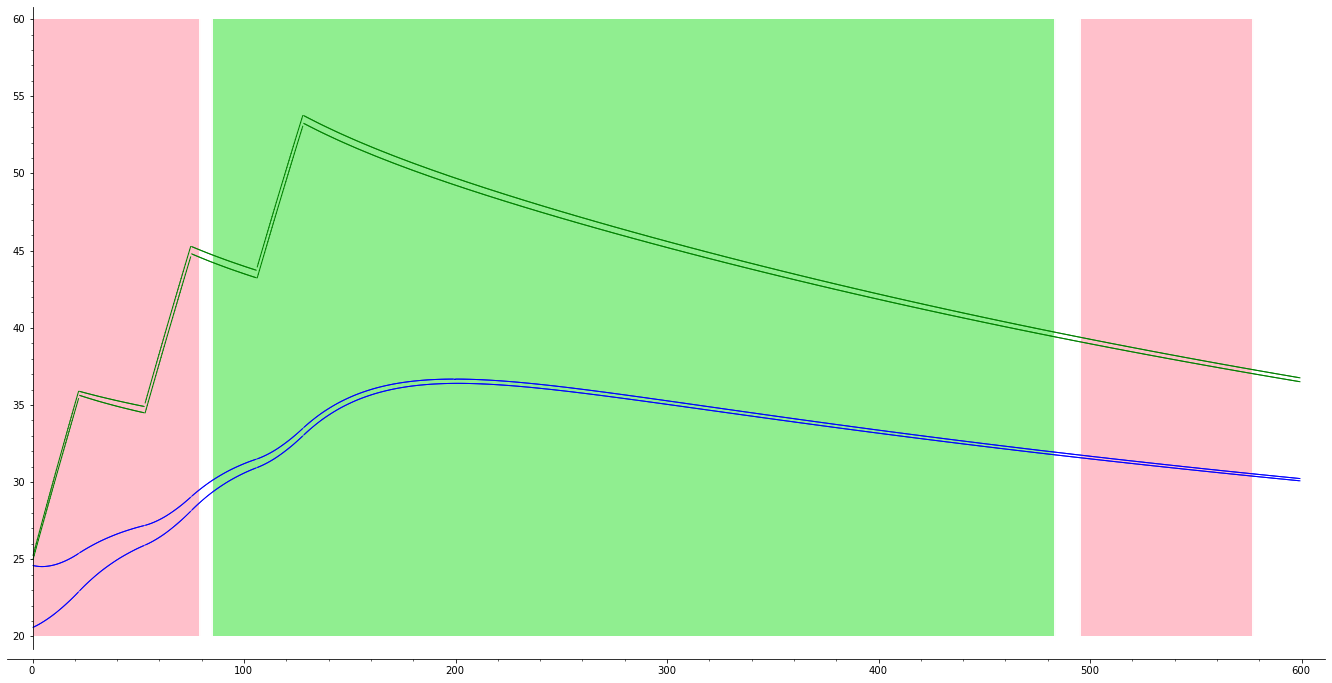

In [25]:
p2 = p + G(RIF(20, 50), Atomic(T_A > RIF(31))).signal(res).plot(y_range=(20, 60))
p2.set_aspect_ratio('automatic')
p2.matplotlib()

mask for F = None


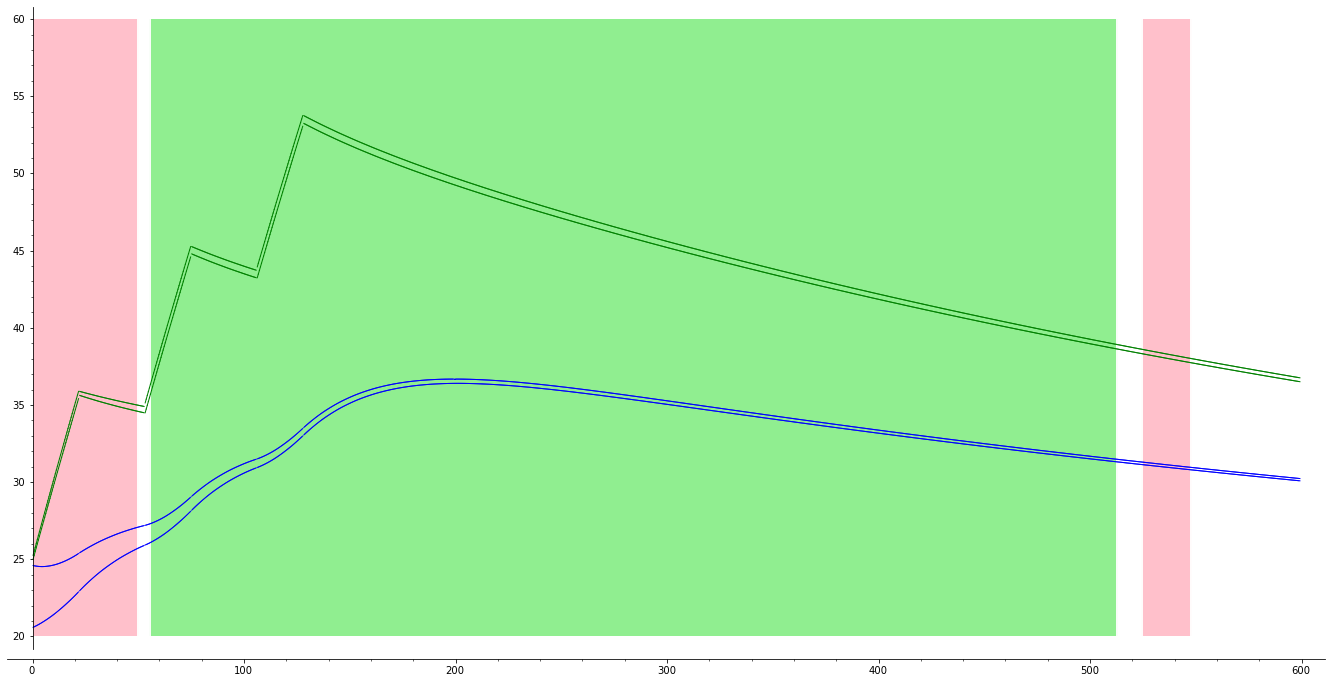

In [26]:
p3 = p + F(RIF(20, 50), Atomic(T_A > RIF(31))).signal(res).plot(y_range=(20, 60))
p3.set_aspect_ratio('automatic')
p3.matplotlib()